In [ ]:
import kagglehub
import pandas as pd
import os

# Download latest version of the dataset
path = kagglehub.dataset_download("khanakshah/microaggressions-in-workplace")

print("Path to dataset files:", path)

# --- Add this line to inspect the contents of the downloaded directory ---
!ls -R {path}
# -----------------------------------------------------------------------

# Construct the full path to the CSV file
# Corrected filename based on `ls -R` output
csv_file_path = os.path.join(path, 'micro_agg.csv')

# Load the dataset into a pandas DataFrame
df_microagg_workplace = pd.read_csv(csv_file_path, encoding='cp1252')

# Display the first 5 rows of the DataFrame
display(df_microagg_workplace.head())

100%|██████████| 2.95k/2.95k [00:00<00:00, 5.21MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/khanakshah/microaggressions-in-workplace/versions/1
/root/.cache/kagglehub/datasets/khanakshah/microaggressions-in-workplace/versions/1:
micro_agg.csv


,speech,label
0,You're very articulate for someone like you.,1
1,Where are you really from?,1
2,You're not like other girls.,1
3,You must be good at math since you're Asian.,1
4,You're too pretty to be a software engineer.,1


In [ ]:
df_microagg_workplace['label'].value_counts()

,count
label,
0,87
1,84


#Average Word Length for Each Label

In [ ]:
(
    df_microagg_workplace
    .assign(
        words=lambda df: df["speech"].str.split(),
        word_lengths=lambda df: df["words"].apply(lambda ws: [len(w) for w in ws]),
        avg_word_len=lambda df: df["word_lengths"].apply(
            lambda ls: sum(ls)/len(ls) if len(ls)>0 else 0
        )
    )
    .groupby("label")["avg_word_len"]
    .mean()
)


,avg_word_len
label,
0,4.998718
1,4.854907


#Average Sentence Length for Each Label

In [ ]:
import re

def avg_sentence_len(text):
    sentences = re.split(r"[.!?]+", text)
    sentences = [s.strip() for s in sentences if s.strip()]  # remove empty splits
    if not sentences:
        return 0
    return sum(len(s.split()) for s in sentences) / len(sentences)

df_microagg_workplace["avg_sentence_len"] = df_microagg_workplace["speech"].apply(avg_sentence_len)

df_microagg_workplace.groupby("label")["avg_sentence_len"].mean()



,avg_sentence_len
label,
0,6.850575
1,6.428571


#Explore Top N-Grams Per Label


In [ ]:
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import string

# Download NLTK resources if not already present
# try:
#     nltk.data.find('corpora/stopwords')
# except nltk.downloader.DownloadError:
#     nltk.download('stopwords')
# try:
#     nltk.data.find('tokenizers/punkt')
# except nltk.downloader.DownloadError:
#     nltk.download('punkt')
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("NLTK resources 'stopwords' and 'punkt' downloaded, and necessary libraries imported.")

NLTK resources 'stopwords' and 'punkt' downloaded, and necessary libraries imported.


In [ ]:
#Now that the necessary libraries are imported and NLTK resources are downloaded, I will create a preprocessing function as instructed.
#This function will convert text to lowercase, remove punctuation, and filter out English stop words, returning a list of cleaned tokens.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Get English stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words and non-alphabetic tokens
    cleaned_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return cleaned_tokens

print("Preprocessing function 'preprocess_text' created successfully.")

Preprocessing function 'preprocess_text' created successfully.


In [ ]:
#To analyze n-grams per label, I need to first separate the data into groups based on their respective labels.
#This will allow for label-specific preprocessing and n-gram extraction.

texts_by_label = (
    df_microagg_workplace
    .groupby('label')['speech']
    .apply(list)
    .to_dict()
)

print({k: len(v) for k, v in texts_by_label.items()})


{0: 87, 1: 84}


In [ ]:
#Now that texts are separated by label, I will process each label's texts to generate unigrams and bigrams, and then count their frequencies.
#This involves applying the previously defined preprocess_text function and using collections.Counter for frequency counting.
import nltk
from nltk.util import ngrams
from collections import Counter

nltk.download('punkt_tab', quiet=True)

unigram_counts_by_label = {}
bigram_counts_by_label = {}

for label, texts in texts_by_label.items():
    all_tokens = []
    all_bigrams = []
    for text in texts:
        cleaned_tokens = preprocess_text(text)
        all_tokens.extend(cleaned_tokens)
        # Generate bigrams, handling cases with less than 2 tokens
        if len(cleaned_tokens) >= 2:
            all_bigrams.extend(list(ngrams(cleaned_tokens, 2)))

    unigram_counts_by_label[label] = Counter(all_tokens)
    bigram_counts_by_label[label] = Counter(all_bigrams)

print("Unigram and bigram counts calculated for each label.")

Unigram and bigram counts calculated for each label.


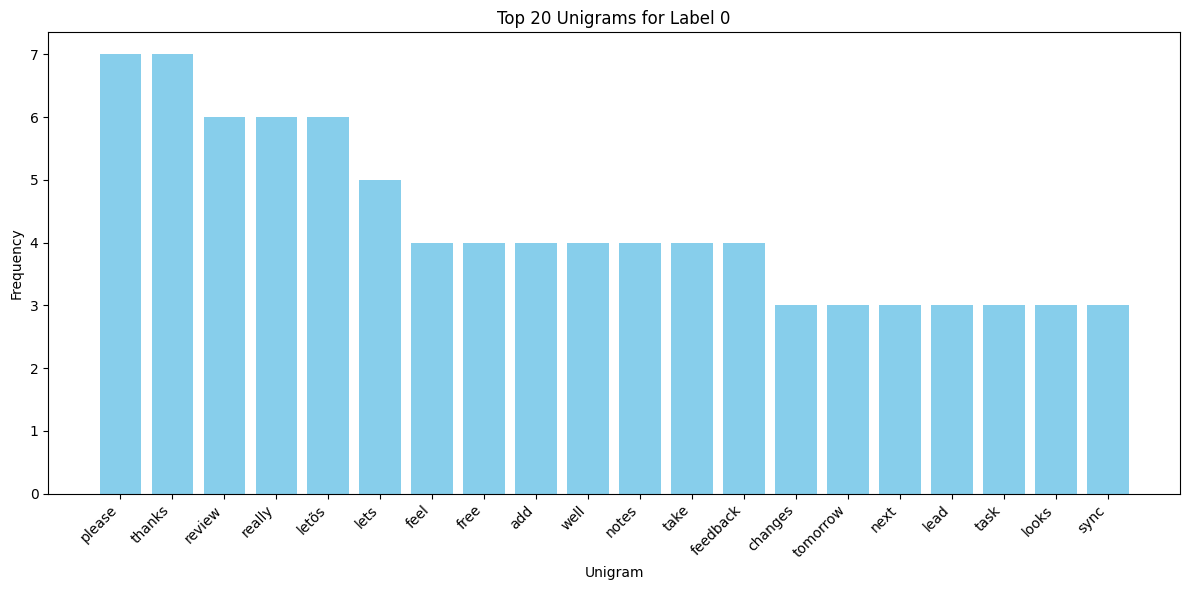

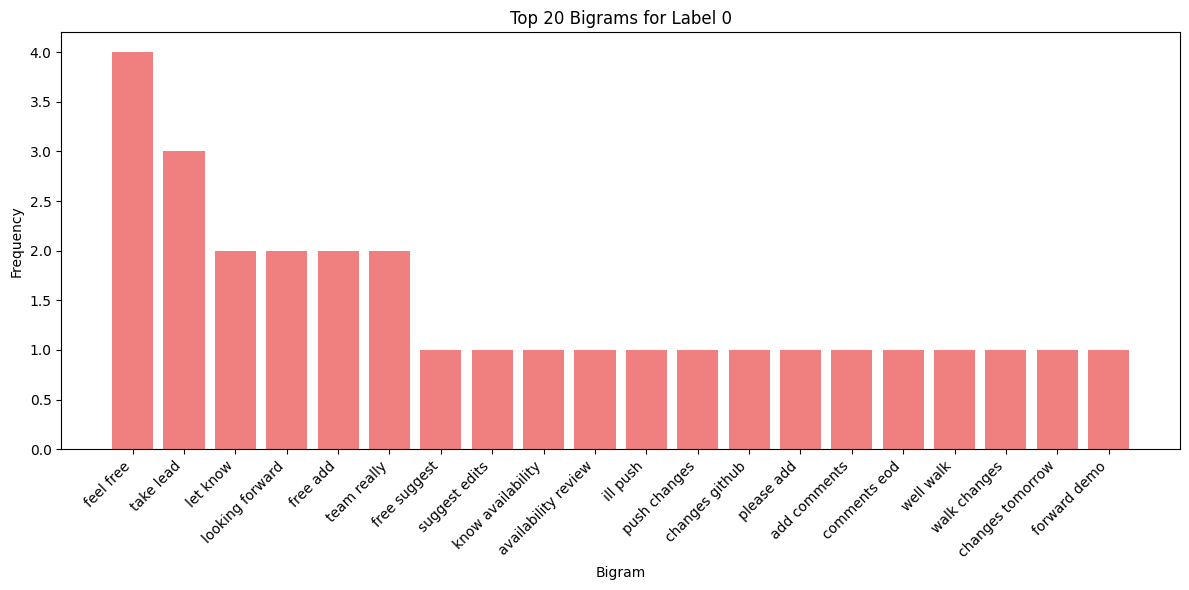

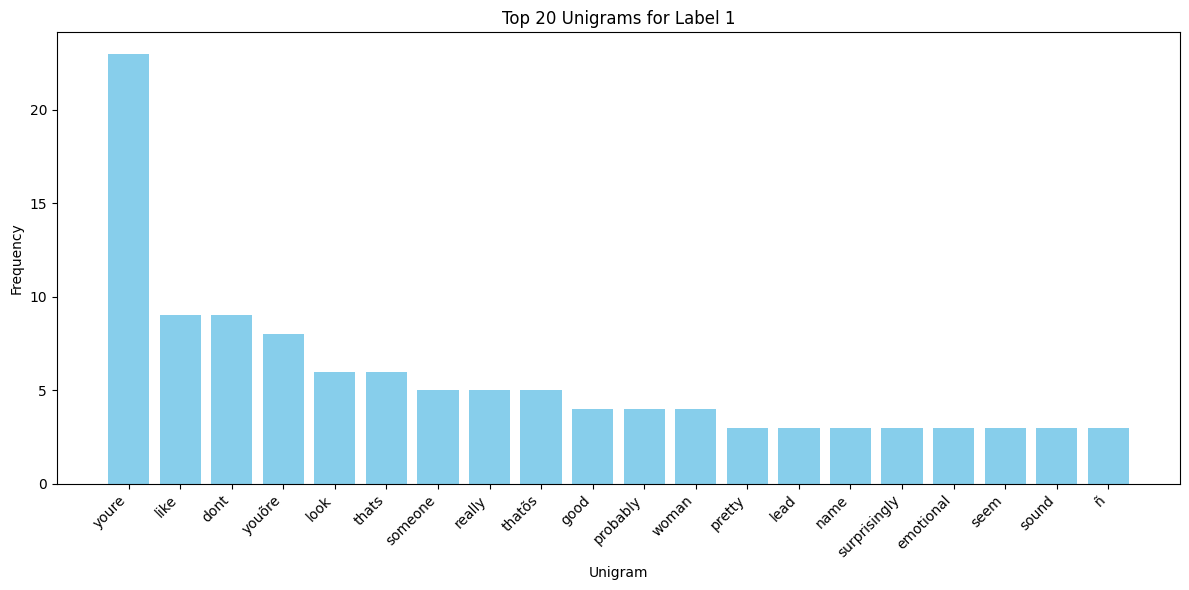

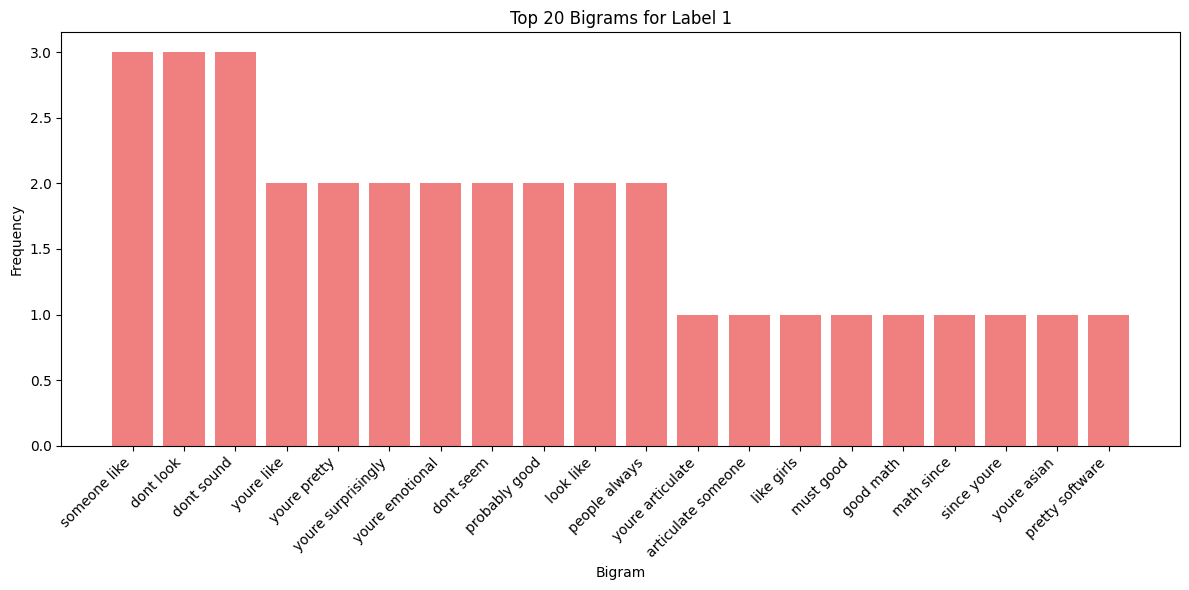

Top 20 unigrams and bigrams visualized for each label.


In [ ]:
#Now that unigram and bigram counts are successfully calculated for each label, I will extract the top 20 most frequent unigrams and bigrams for each label. Then, I will create bar charts to visualize these top N-grams, ensuring clear titles, labels, and
#readable formatting for each plot.

for label in sorted(unigram_counts_by_label.keys()):
    # Get top 20 unigrams
    top_unigrams = unigram_counts_by_label[label].most_common(20)
    words_uni = [word for word, count in top_unigrams]
    counts_uni = [count for word, count in top_unigrams]

    # Plotting top 20 unigrams
    plt.figure(figsize=(12, 6))
    plt.bar(words_uni, counts_uni, color='skyblue')
    plt.xlabel('Unigram')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Unigrams for Label {label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Get top 20 bigrams
    top_bigrams = bigram_counts_by_label[label].most_common(20)
    words_bi = [' '.join(word) for word, count in top_bigrams]
    counts_bi = [count for word, count in top_bigrams]

    # Plotting top 20 bigrams
    plt.figure(figsize=(12, 6))
    plt.bar(words_bi, counts_bi, color='lightcoral')
    plt.xlabel('Bigram')
    plt.ylabel('Frequency')
    plt.title(f'Top 20 Bigrams for Label {label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("Top 20 unigrams and bigrams visualized for each label.")

#View Full Text of All Entries

In [ ]:
#see full text length

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

df_microagg_workplace[["speech", "label"]]






,speech,label
0,You're very articulate for someone like you.,1
1,Where are you really from?,1
2,You're not like other girls.,1
3,You must be good at math since you're Asian.,1
4,You're too pretty to be a software engineer.,1
5,Are you sure you want to lead this project?,1
6,You don't look gay.,1
7,You are a credit to your race.,1
8,"That's a strange name, is it foreign?",1
9,Do you even understand this topic?,1


#Explore Semantic Clustering to Gauge if Entries are Trivially Distinguishable

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster label counts:
 cluster
 1    84
 0    76
-1    11
Name: count, dtype: int64 

Cluster vs. Gold Label:
label     0   1
cluster        
-1        3   8
 0        2  74
 1       82   2

Cluster majority labels:
 cluster
0    1
1    0
Name: majority_label, dtype: int64


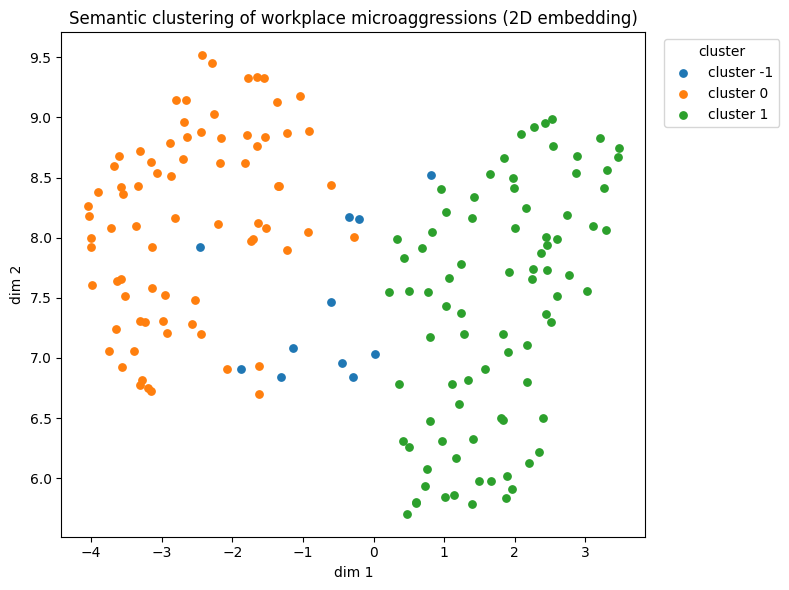

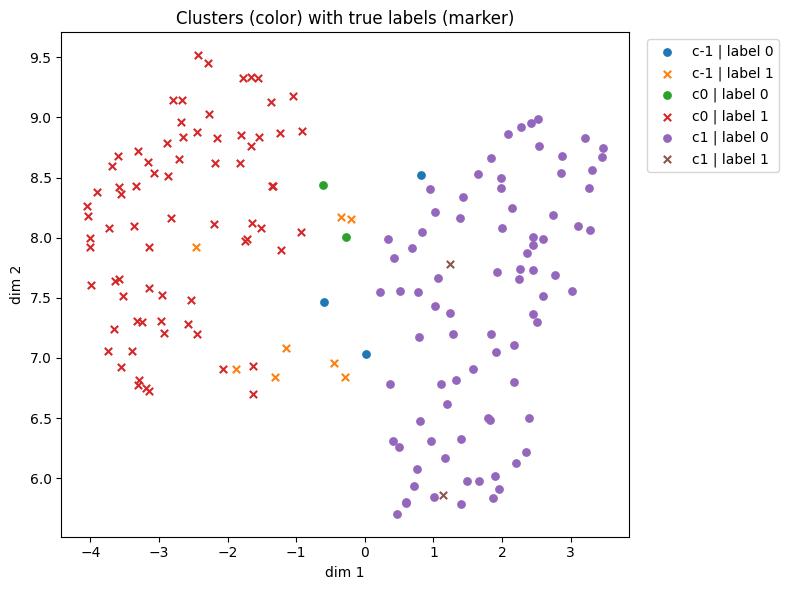

In [ ]:

!pip install -q sentence-transformers umap-learn hdbscan matplotlib scikit-learn pandas


import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False

try:
    import hdbscan
    HDBSCAN_AVAILABLE = True
except Exception:
    HDBSCAN_AVAILABLE = False

from sklearn.cluster import KMeans

df = df_microagg_workplace.copy()

# Clean up text column
df["speech"] = df["speech"].astype(str).str.strip()
df = df[df["speech"].str.len() > 0].reset_index(drop=True)

texts = df["speech"].tolist()
labels = df["label"].tolist() if "label" in df.columns else None

#Embed
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)

#Dimensionality reduction to 2D for plotting

if UMAP_AVAILABLE:
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric="cosine",
        random_state=42
    )
    X_2d = reducer.fit_transform(embeddings)
else:
    X_2d = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=42,
        metric="cosine"
    ).fit_transform(embeddings)

#Clustering

if HDBSCAN_AVAILABLE:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=10,
        min_samples=5,
        metric="euclidean"
    ).fit(X_2d)
    cluster_labels = clusterer.labels_  # -1 are noise points
else:
    # Fallback: KMeans with model selection via silhouette on a small range
    best_k, best_score, best_labels = None, -1, None
    for k in range(2, 9):
        kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
        labs = kmeans.fit_predict(embeddings)  # use full embeddings for clustering
        try:
            score = silhouette_score(embeddings, labs, metric="cosine")
        except Exception:
            score = -1
        if score > best_score:
            best_k, best_score, best_labels = k, score, labs
    cluster_labels = best_labels

# Attach results back to the DataFrame
df["cluster"] = cluster_labels
df["x"], df["y"] = X_2d[:, 0], X_2d[:, 1]

#Quick diagnostics
print("Cluster label counts:\n", df["cluster"].value_counts(dropna=False), "\n")

if labels is not None and (df["cluster"] >= 0).any():
    # Crosstab cluster vs. gold label (ignoring noise = -1 if HDBSCAN)
    print("Cluster vs. Gold Label:")
    print(pd.crosstab(df["cluster"], df["label"]))

    # Simple "purity-ish" view: majority label per cluster
    majority = (
        df[df["cluster"] >= 0]
        .groupby("cluster")["label"]
        .agg(lambda s: s.value_counts().idxmax())
        .rename("majority_label")
    )
    print("\nCluster majority labels:\n", majority)

# Silhouette (only if no -1 and at least 2 clusters)
if (df["cluster"] >= 0).nunique() > 1 and not (df["cluster"] == -1).any():
    try:
        sil = silhouette_score(embeddings, df["cluster"], metric="cosine")
        print(f"\nSilhouette score (cosine): {sil:.3f}")
    except Exception:
        pass

#  Visualization
plt.figure(figsize=(8, 6))
unique_clusters = sorted(df["cluster"].unique())
for c in unique_clusters:
    mask = df["cluster"] == c
    plt.scatter(df.loc[mask, "x"], df.loc[mask, "y"], s=28, label=f"cluster {c}")
plt.title("Semantic clustering of workplace microaggressions (2D embedding)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.legend(title="cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ── 9) (Optional) Compare cluster purity by label visually ─────────────────────
if labels is not None:
    plt.figure(figsize=(8, 6))
    # Use markers to encode true label (e.g., 0 = 'o', 1 = 'x')
    markers = {0: "o", 1: "x"}
    for c in unique_clusters:
        mask_c = df["cluster"] == c
        for lab in sorted(df["label"].unique()):
            mask = mask_c & (df["label"] == lab)
            plt.scatter(df.loc[mask, "x"], df.loc[mask, "y"], s=28,
                        marker=markers.get(lab, "o"),
                        label=f"c{c} | label {lab}")
    plt.title("Clusters (color) with true labels (marker)")
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    # Build a compact legend
    handles, labels_ = plt.gca().get_legend_handles_labels()
    by_name = dict(zip(labels_, handles))
    plt.legend(by_name.values(), by_name.keys(), bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
